In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, levene
import warnings
import folium
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [16]:
mma = pd.read_csv("Desktop/MMA.csv")

# Exploratory Data Analysis


## Basic Information 

In [18]:
mma.head()

,age,job,marital,k,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,...,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,...,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,...,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,...,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


In [24]:
mma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4100 entries, 0 to 4099
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4100 non-null   int64  
 1   job             4100 non-null   object 
 2   marital         4100 non-null   object 
 3   k               4100 non-null   object 
 4   default         4100 non-null   object 
 5   housing         4100 non-null   object 
 6   loan            4100 non-null   object 
 7   contact         4100 non-null   object 
 8   month           4100 non-null   object 
 9   day_of_week     4100 non-null   object 
 10  duration        4100 non-null   int64  
 11  campaign        4100 non-null   int64  
 12  pdays           4100 non-null   int64  
 13  previous        4100 non-null   int64  
 14  poutcome        4100 non-null   object 
 15  emp.var.rate    4100 non-null   float64
 16  cons.price.idx  4100 non-null   float64
 17  cons.conf.idx   4100 non-null   f

In [26]:
mma.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4100.000000,4100.000000,4100.000000,4100.000000,4100.000000,4100.000000,4100.000000,4100.000000,4100.000000,4100.000000
mean,40.117073,256.754634,2.538537,960.243415,0.190732,0.085171,93.580123,-40.498463,3.621421,5166.472780
std,10.315182,254.399637,2.568833,192.349065,0.542609,1.563183,0.579578,4.593385,1.733708,73.664618
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [227]:
def check_missing_data(df):
    missing_counts = df.isnull().sum()
    missing_perc = (missing_counts / len(df)) * 100

    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing %': missing_perc
    })

    missing_summary = missing_summary[missing_summary['Missing Count'] > 0]
    
    if missing_summary.empty:
        print("✅ No missing values found.")
    else:
        print("❗ Missing Data Found:")
        display(missing_summary.sort_values(by='Missing %', ascending=False))
        
check_missing_data(mma)

✅ No missing values found.


In [229]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [233]:
def check_unknown_values(df):
    unknown_summary = {}

    for col in df.select_dtypes(include='object'):
        unknown_count = df[col].isin(['unknown']).sum()
        if unknown_count > 0:
            unknown_summary[col] = unknown_count

    if unknown_summary:
        print("🔍 Columns with 'unknown' values (pseudo-missing):")
        for col, count in unknown_summary.items():
            print(f"{col}: {count} entries ({(count/len(df))*100:.2f}%)")
    else:
        print("✅ No 'unknown' values found in object columns.")
        
check_unknown_values(mma)

🔍 Columns with 'unknown' values (pseudo-missing):
job: 39 entries (0.95%)
marital: 11 entries (0.27%)
k: 167 entries (4.07%)
default: 799 entries (19.49%)
housing: 104 entries (2.54%)
loan: 104 entries (2.54%)


## Data Cleansing Strategy comp

In [237]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def clean_unknowns(df, strategy='missing'):
    df_clean = df.copy()
    for col in ['default', 'k', 'housing', 'loan', 'job', 'marital']:
        if strategy == 'missing':
            df_clean[col] = df_clean[col].replace('unknown', 'missing')
        elif strategy == 'mode':
            mode_val = df_clean[col][df_clean[col] != 'unknown'].mode()[0]
            df_clean[col] = df_clean[col].replace('unknown', mode_val)
    return df_clean

def prepare_model_data(df):
    df_model = df.copy()

    X = df_model.drop('y', axis=1)
    y = df_model['y']

    X_encoded = X.copy()
    for col in X_encoded.select_dtypes(include='object').columns:
        X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

    y_encoded = LabelEncoder().fit_transform(y)  # Encode target ('no'=0, 'yes'=1)

    return train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

def evaluate_model(X_train, X_test, y_train, y_test, title="Model"):
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"🔍 {title} - Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['no', 'yes']))
    return acc

mma_missing = clean_unknowns(mma, strategy='missing')
mma_mode = clean_unknowns(mma, strategy='mode')

X_train_miss, X_test_miss, y_train_miss, y_test_miss = prepare_model_data(mma_missing)
X_train_mode, X_test_mode, y_train_mode, y_test_mode = prepare_model_data(mma_mode)

acc_missing = evaluate_model(X_train_miss, X_test_miss, y_train_miss, y_test_miss, title="Missing Strategy")
acc_mode = evaluate_model(X_train_mode, X_test_mode, y_train_mode, y_test_mode, title="Mode Imputation Strategy")


🔍 Missing Strategy - Accuracy: 0.9171
              precision    recall  f1-score   support

          no       0.94      0.97      0.95       737
         yes       0.62      0.47      0.53        83

    accuracy                           0.92       820
   macro avg       0.78      0.72      0.74       820
weighted avg       0.91      0.92      0.91       820

🔍 Mode Imputation Strategy - Accuracy: 0.9171
              precision    recall  f1-score   support

          no       0.94      0.97      0.95       737
         yes       0.62      0.46      0.53        83

    accuracy                           0.92       820
   macro avg       0.78      0.71      0.74       820
weighted avg       0.91      0.92      0.91       820



### Accuracy is identical with both strategies, however handling unknown as it's own category performs better on recall (catches more yes responses 47% vs 46%), and it gives a slight edge in macro average, which is good since out ds is a bit unbalanced. Using missing as a cathegory will be good for tree-based models, and unknown can re0resent a real signal such as customers refusing to answer. This helps with avoiding assumptions in data. 

In [242]:
def clean_unknowns(mma):
    mma_clean = mma.copy()
    for col in ['default', 'k', 'housing', 'loan', 'job', 'marital']:
        mma_clean[col] = mma_clean[col].replace('unknown', 'missing')
    return mma_clean

mma_cleaned = clean_unknowns(mma)

In [284]:
mma = clean_unknowns(mma)

In [327]:
def confirm_no_unknowns(df):
    unknown_summary = {}

    for col in mma.select_dtypes(include='object'):
        unknown_count = mma[col].isin(['unknown']).sum()
        if unknown_count > 0:
            unknown_summary[col] = unknown_count

    if unknown_summary:
        return pd.DataFrame.from_dict(unknown_summary, orient='index', columns=['Still Unknown'])
    else:
        return "✅ All 'unknown' values successfully replaced."


mma = clean_unknowns(mma)

confirm_no_unknowns(mma)


"✅ All 'unknown' values successfully replaced."

## Distribution of cathegorical and numerical variables

## Distribution of numerical variables

In [287]:
sns.set(style="whitegrid")

In [289]:
numerical_cols = mma.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = mma.select_dtypes(include='object').columns.tolist()

In [291]:
import matplotlib.pyplot as plt
import seaborn as sns

In [293]:
%matplotlib inline

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_numerical_distributions(mma, num_cols, max_plots=6):
   
    cols_to_plot = num_cols[:max_plots]

    for col in cols_to_plot:
        plt.figure(figsize=(8, 4))
        sns.histplot(
            mma[col],
            kde=True,
            bins=30,
            color="#94a2d4",  # Pink bars
            line_kws={"color": "#94a2d4", "linewidth": 2} 
        )
        plt.title(f'Distribution of {col}', color="#94a2d4", fontsize=14)
        plt.xlabel(col, color="#94a2d4")
        plt.ylabel('Frequency', color="#94a2d4")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tick_params(colors="#94a2d4")
        plt.tight_layout()
        plt.show()



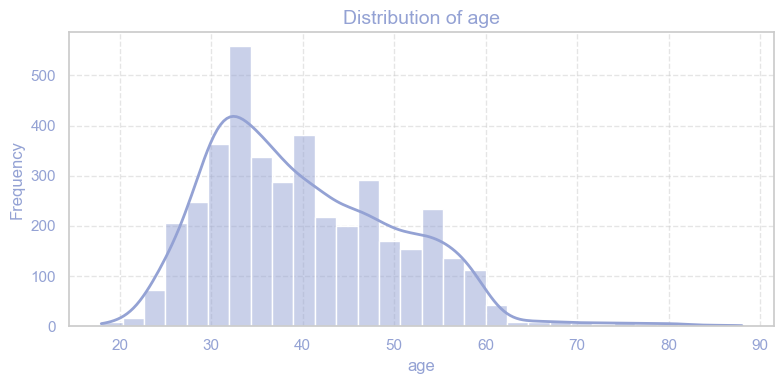

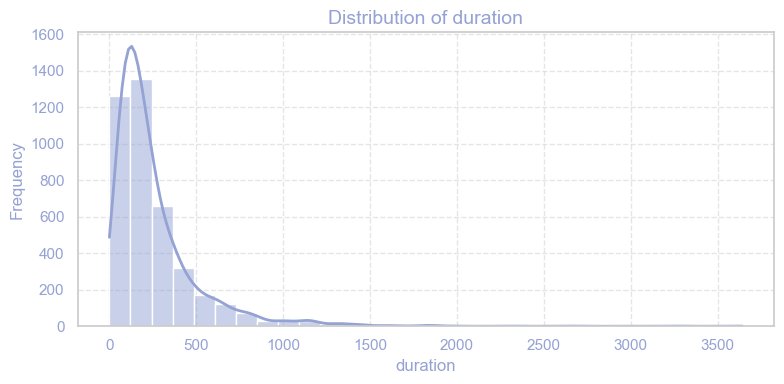

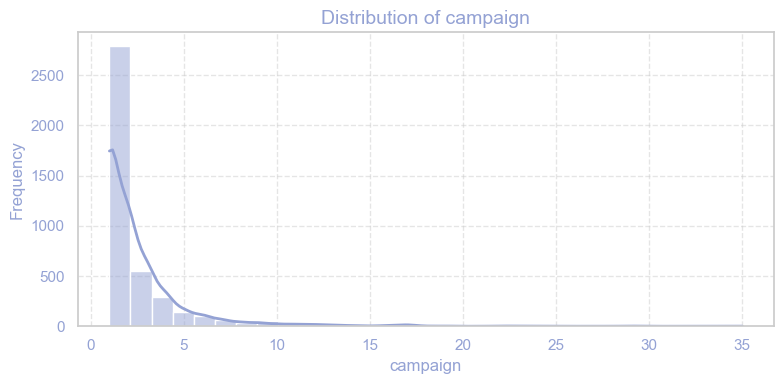

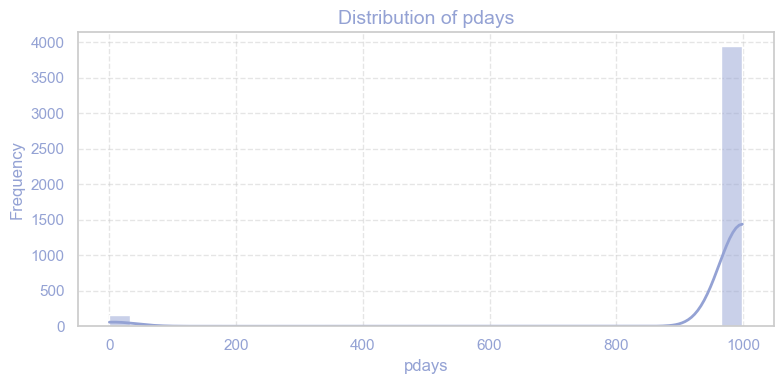

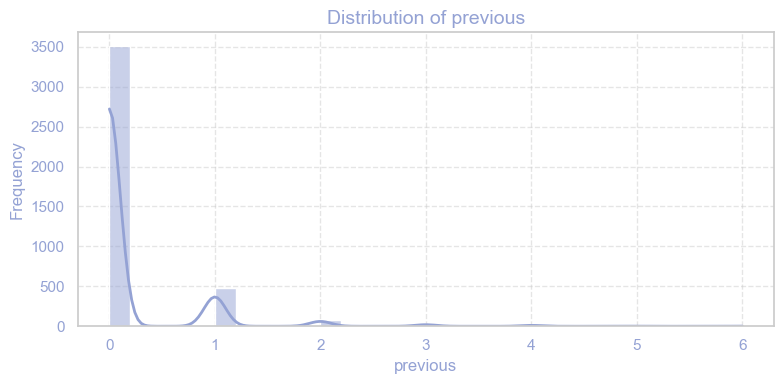

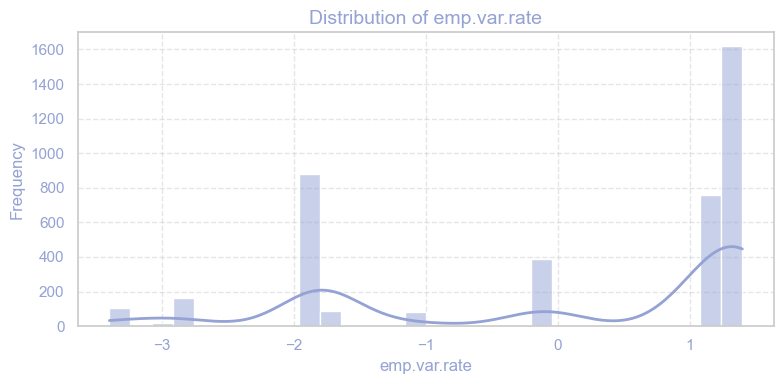

In [299]:
plot_numerical_distributions(mma, numerical_cols)


## Another way to visualise the distribution of numerical variables

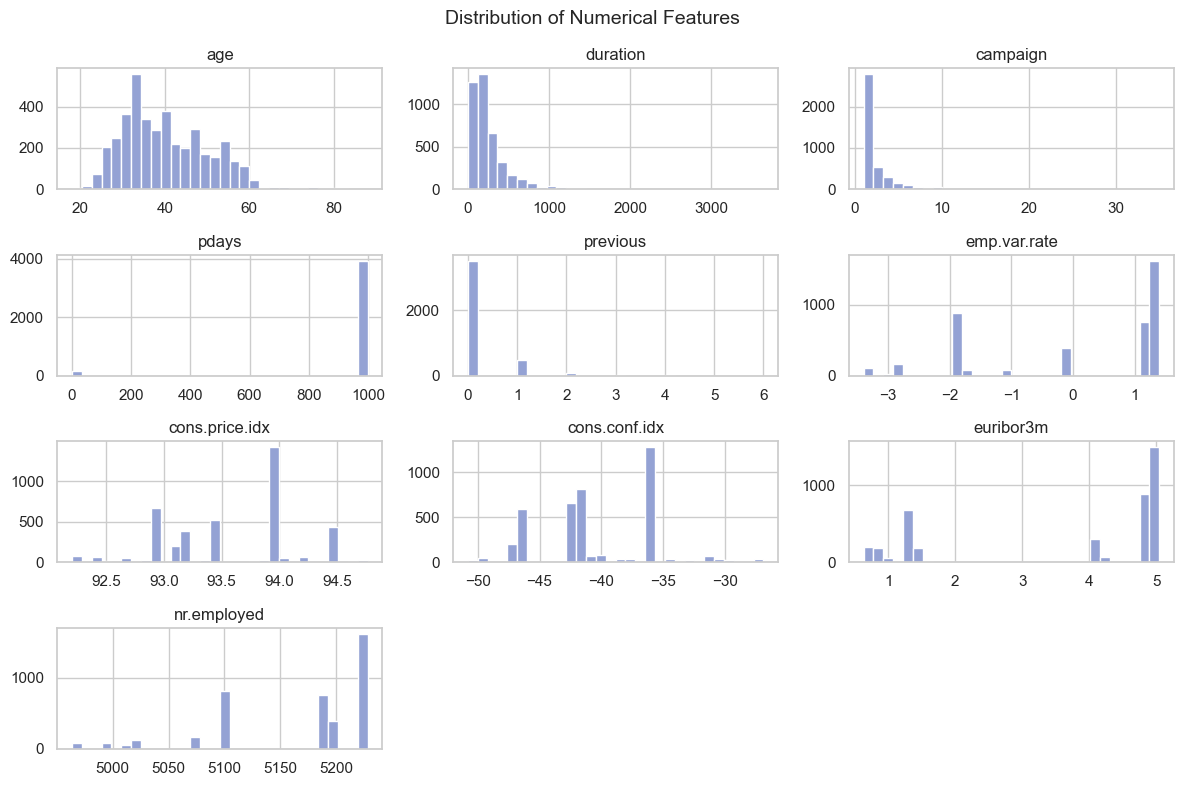

In [334]:
mma.select_dtypes(include=['int64', 'float64']).hist(figsize=(12, 8), bins=30, color='#94a2d4')
plt.suptitle("Distribution of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

## Count plot for target var

In [301]:
import matplotlib.pyplot as plt
import seaborn as sns

pastel_palette = ["#ff69b4", "#87cefa", "#ffb6c1", "#add8e6", "#db3eb1", "#4169e1"]

def plot_categorical_counts(mma, cat_cols, max_plots=6):
    
    cols_to_plot = cat_cols[:max_plots]

    for col in cols_to_plot:
        plt.figure(figsize=(10, 4))
        sns.countplot(
            data=mma,
            x=col,
            order=mma[col].value_counts().index,
            palette=pastel_palette  # Apply custom color palette
        )
        plt.title(f'Count Plot of {col}', color="#18203d", fontsize=14)
        plt.xlabel(col, color="#18203d")
        plt.ylabel("Count", color="#18203d")
        plt.xticks(rotation=45, color="#18203d")
        plt.yticks(color="#18203d")
        plt.grid(axis="y", linestyle="--", alpha=0.3)
        plt.tight_layout()
        plt.show


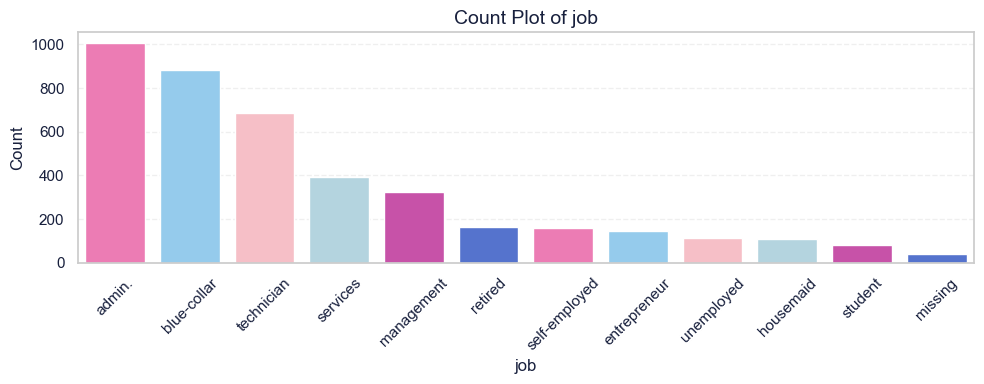

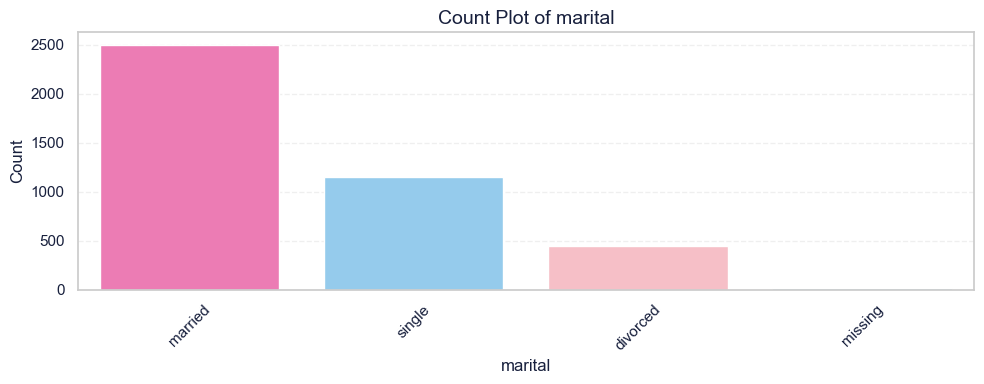

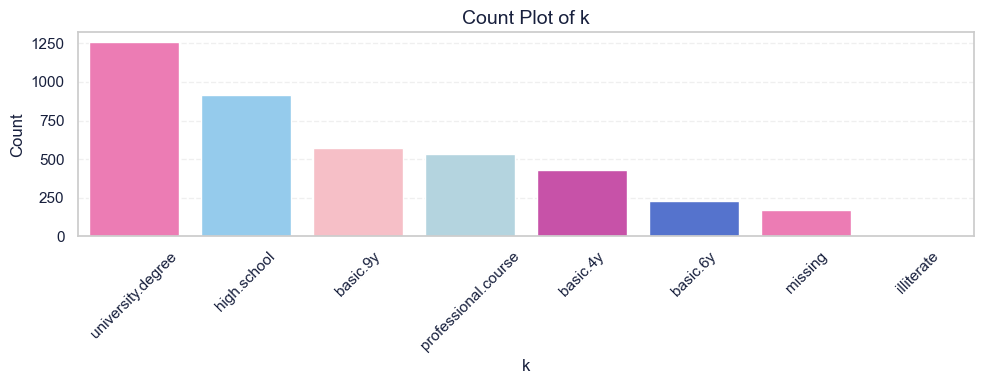

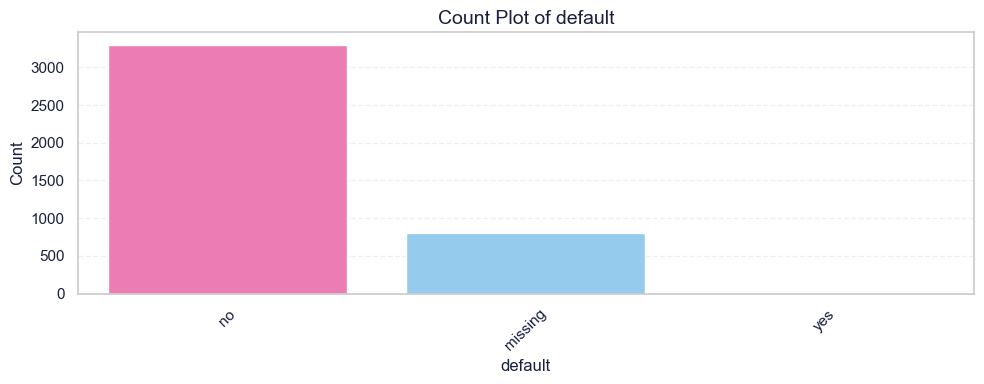

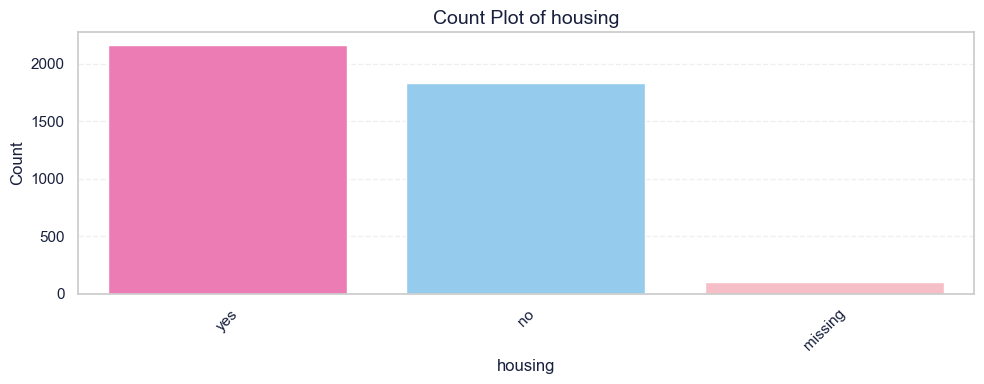

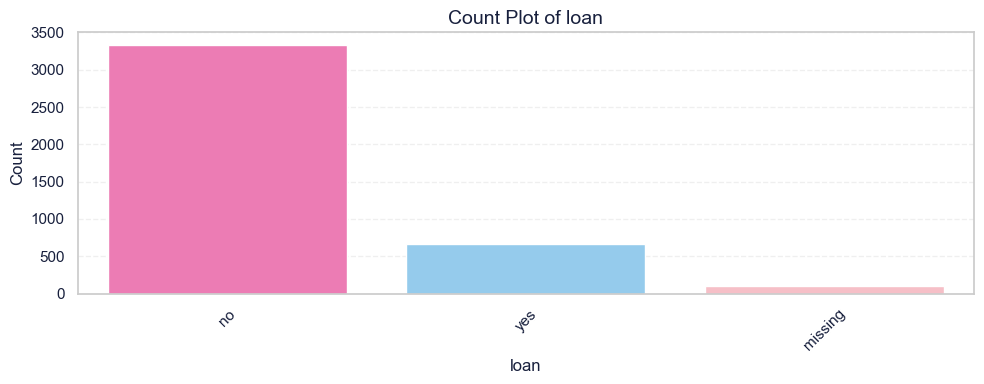

In [303]:
plot_categorical_counts(mma, categorical_cols)

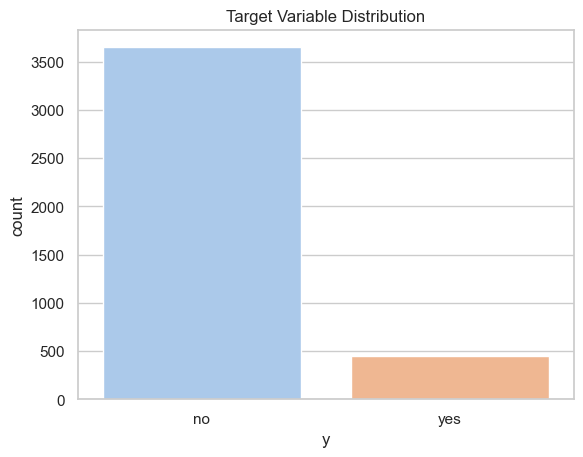

In [336]:
sns.countplot(data=mma, x='y', palette='pastel')
plt.title("Target Variable Distribution")
plt.show()

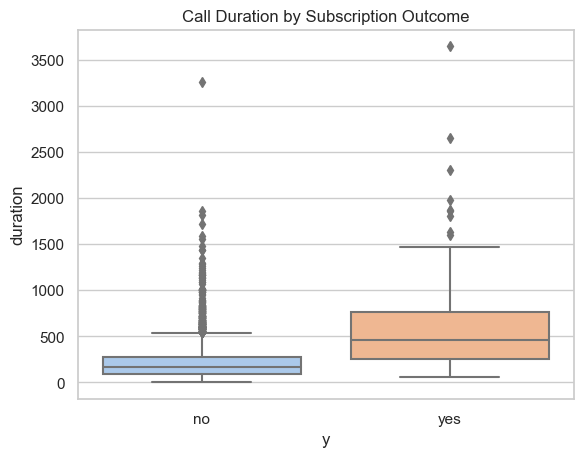

In [339]:
sns.boxplot(data=mma, x='y', y='duration', palette='pastel')
plt.title("Call Duration by Subscription Outcome")
plt.show()

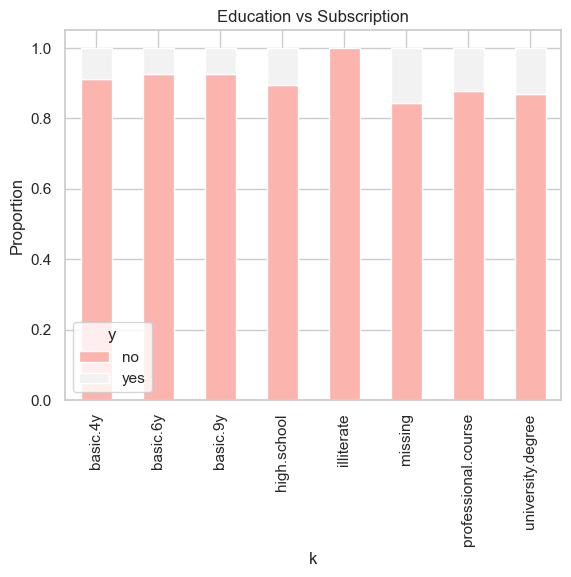

In [341]:
pd.crosstab(mma['k'], mma['y'], normalize='index').plot(kind='bar', stacked=True, colormap='Pastel1')
plt.title("Education vs Subscription")
plt.ylabel("Proportion")
plt.show()

## Correlation Heatmap

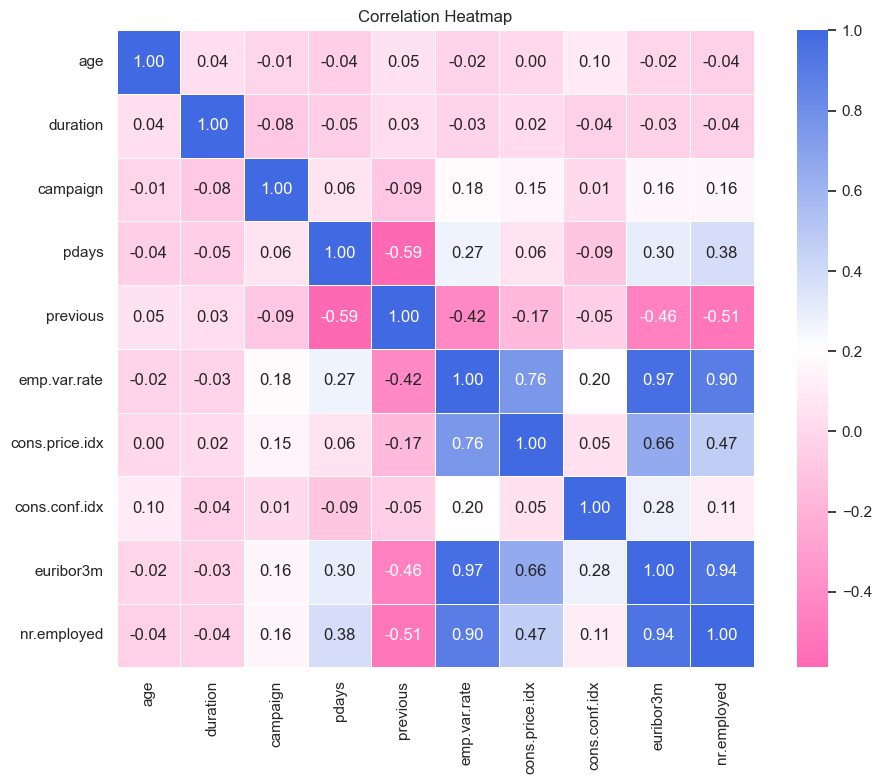

In [305]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

pink_blue = LinearSegmentedColormap.from_list("pink_blue", ["#ff69b4", "#ffffff", "#4169e1"])

def plot_correlation_heatmap(mma, num_cols):
   
    plt.figure(figsize=(10, 8))
    corr = mma[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap=pink_blue, square=True, linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.tight_layout()
    plt.show()

plot_correlation_heatmap(mma, numerical_cols)

## Different variables against target y

In [307]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_boxplots_vs_target(df, num_cols, target, max_plots=6):

    pastel_colors = ["#fbc1fe", "#94a2d4"] 
    cols_to_plot = num_cols[:max_plots]

    for col in cols_to_plot:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=target, y=col, data=df, palette=pastel_colors)
        plt.title(f'{col} vs {target}', color="#18203d", fontsize=14)
        plt.xlabel(target, color="#18203d")
        plt.ylabel(col, color="#18203d")
        plt.xticks(color="#18203d")
        plt.yticks(color="#18203d")
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.tight_layout()
        plt.show()


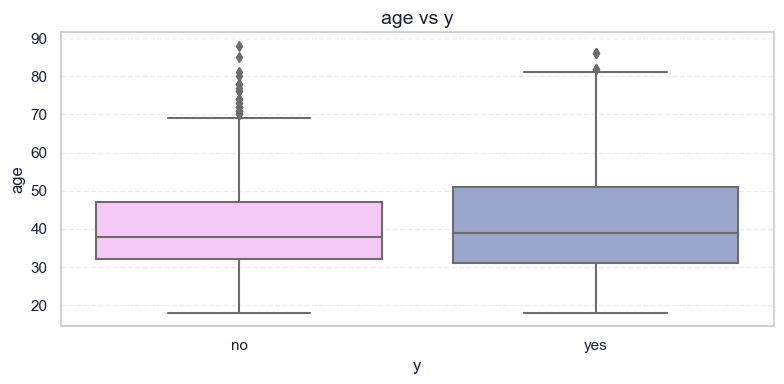

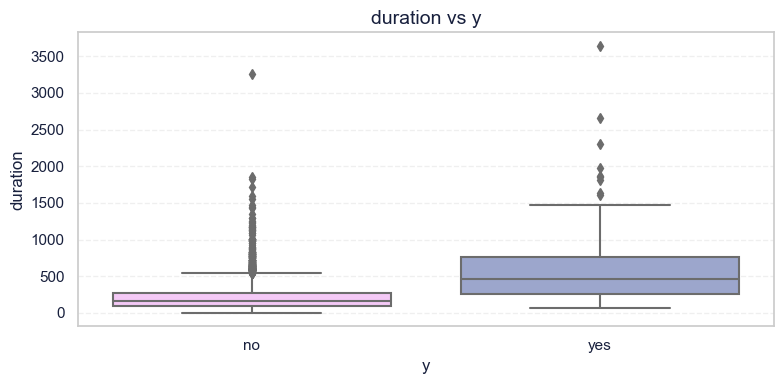

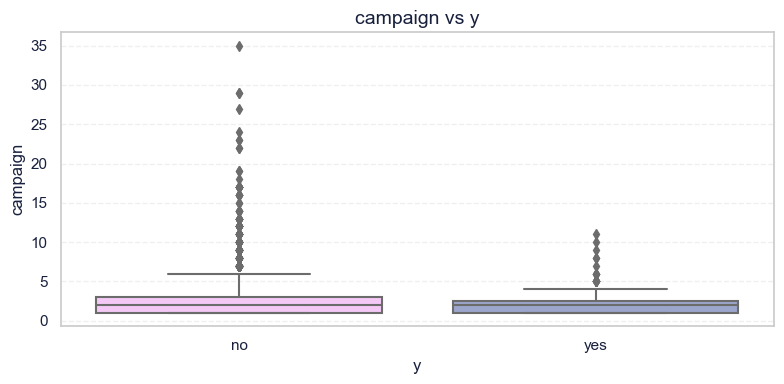

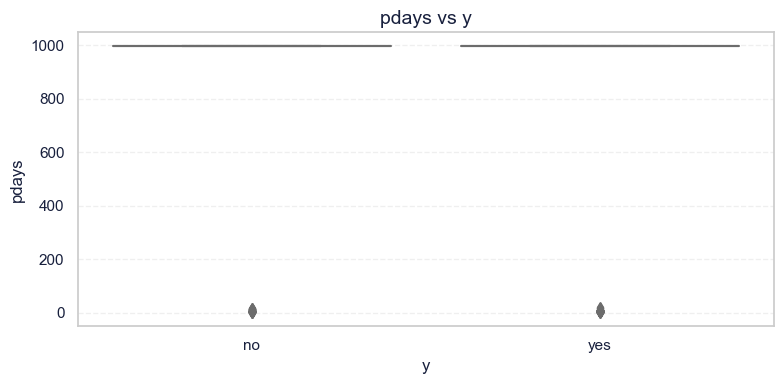

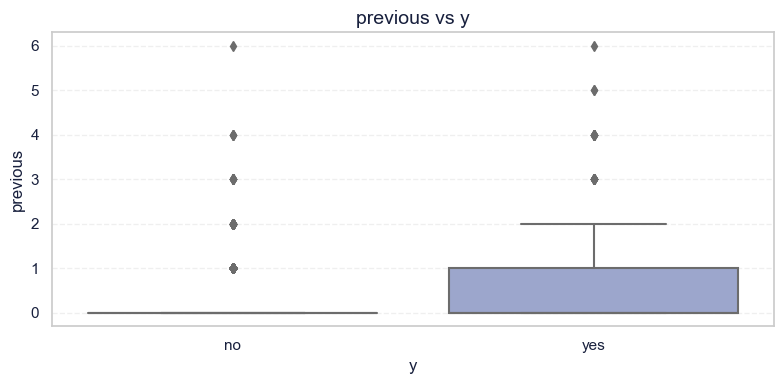

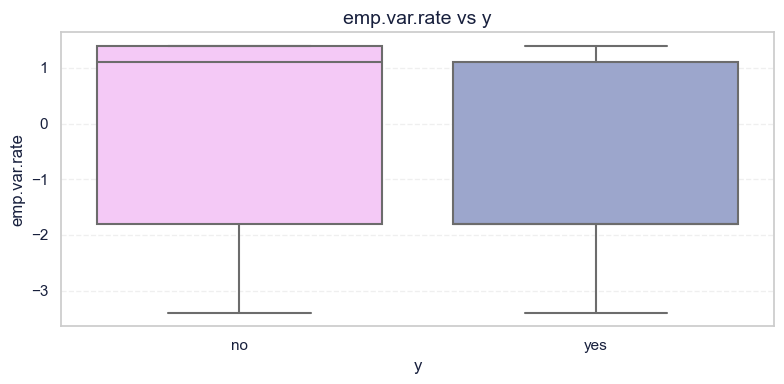

In [309]:
plot_boxplots_vs_target(mma, numerical_cols, target='y')


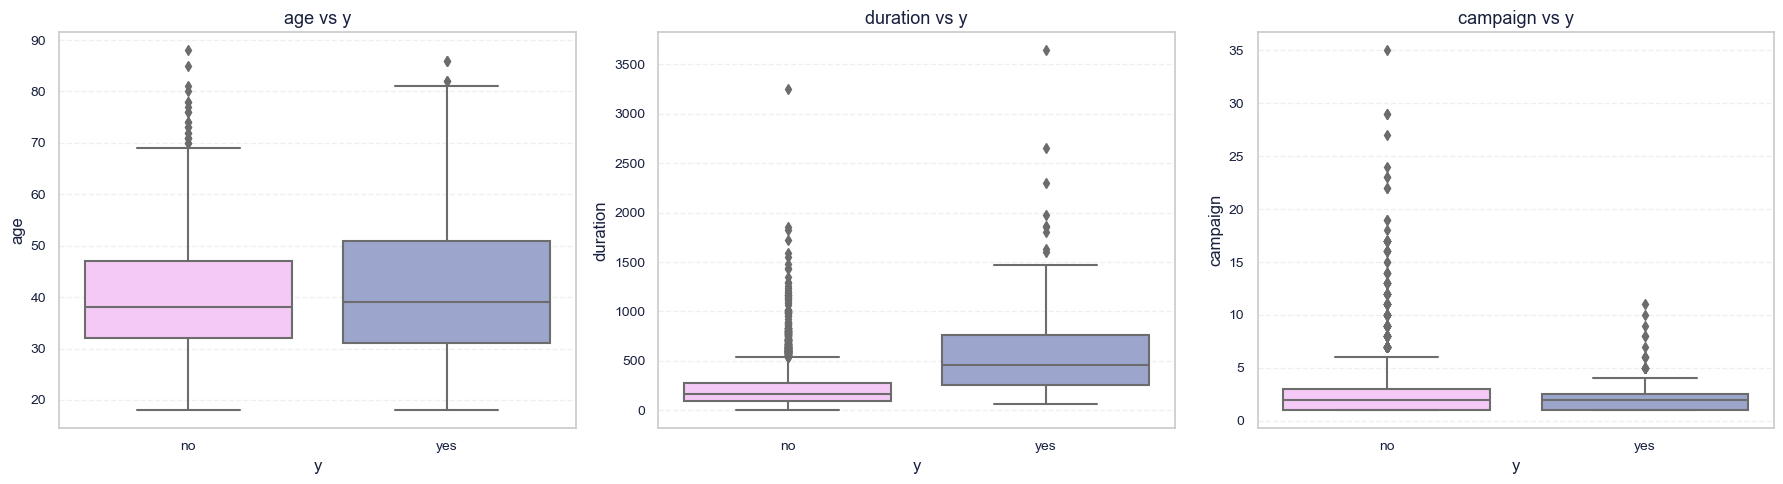

In [463]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_selected_boxplots_vs_target(df, target):
    pastel_colors = ["#fbc1fe", "#94a2d4"]
    selected_cols = ['age', 'duration', 'campaign']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

    for i, col in enumerate(selected_cols):
        sns.boxplot(x=target, y=col, data=df, palette=pastel_colors, ax=axes[i])
        axes[i].set_title(f'{col} vs {target}', color="#18203d", fontsize=13)
        axes[i].set_xlabel(target, color="#18203d")
        axes[i].set_ylabel(col, color="#18203d")
        axes[i].tick_params(colors="#18203d", labelsize=10)
        axes[i].grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_selected_boxplots_vs_target(mma, target="y")


In [311]:
def plot_cat_vs_target(df, cat_cols, target, max_plots=6):
    # Custom lavender and soft pink
    custom_colors = ["#b4b2f8", "#f6b1c3"]  # Lavender (no), Soft pink (yes)
    cols_to_plot = cat_cols[:max_plots]

    for col in cols_to_plot:
        plt.figure(figsize=(10, 4))

        prop_df = df.groupby(col)[target].value_counts(normalize=True).unstack().fillna(0)

        if 'yes' in prop_df.columns and 'no' in prop_df.columns:
            prop_df = prop_df[['no', 'yes']]
        else:
            prop_df = prop_df[prop_df.columns[::-1]]

        prop_df.plot(
            kind='bar',
            stacked=True,
            color=custom_colors,
            edgecolor='white',
            width=0.8
        )

        plt.title(f'{col} vs {target}', color="#18203d", fontsize=14)
        plt.ylabel('Proportion', color="#18203d")
        plt.xlabel(col, color="#18203d")
        plt.xticks(rotation=45, color="#18203d")
        plt.yticks(color="#18203d")
        plt.grid(axis='y', linestyle='--', alpha=0.3)
        plt.legend(title=target, loc='upper right')
        plt.tight_layout()
        plt.show()


<Figure size 1000x400 with 0 Axes>

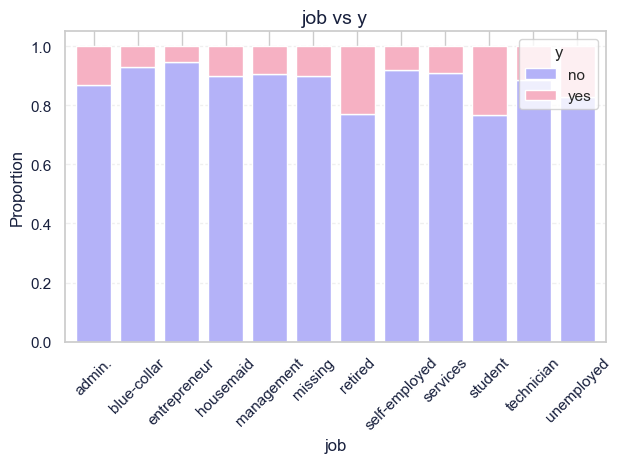

<Figure size 1000x400 with 0 Axes>

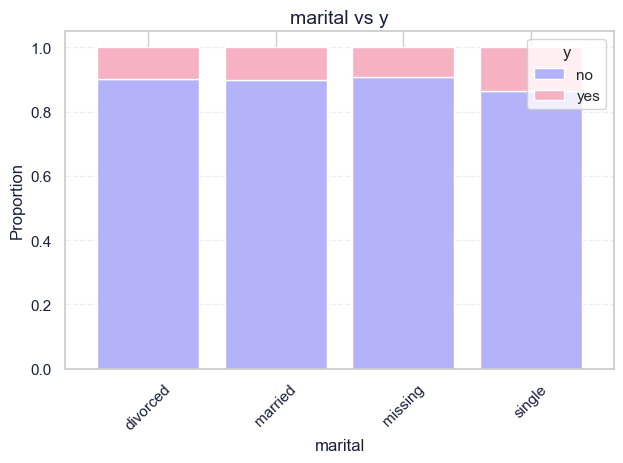

<Figure size 1000x400 with 0 Axes>

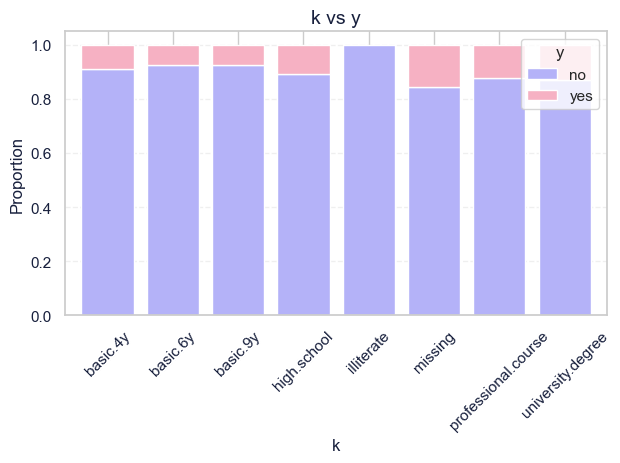

<Figure size 1000x400 with 0 Axes>

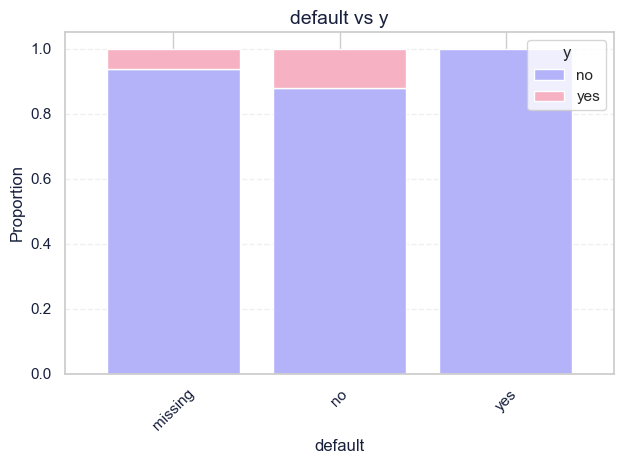

<Figure size 1000x400 with 0 Axes>

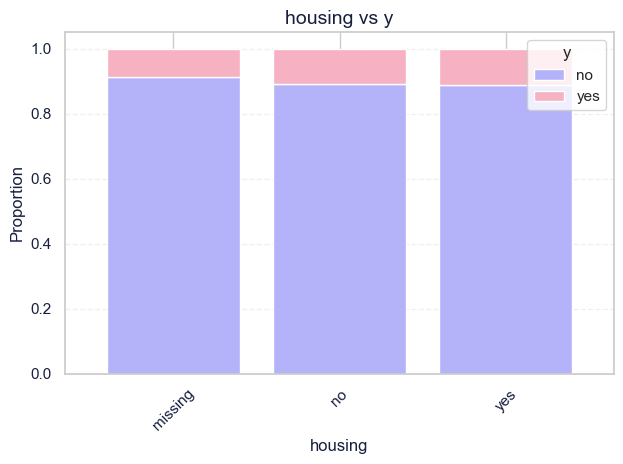

<Figure size 1000x400 with 0 Axes>

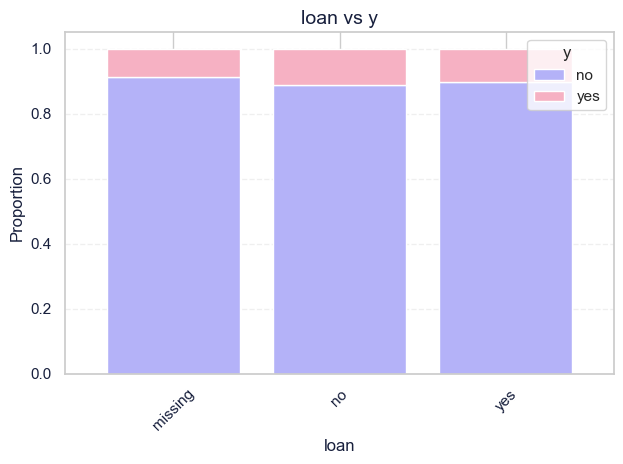

In [313]:
plot_cat_vs_target(mma, categorical_cols, target='y')


## Class balance

In [315]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = mma.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = mma.select_dtypes(include='object').columns.tolist()
target_col = 'y'

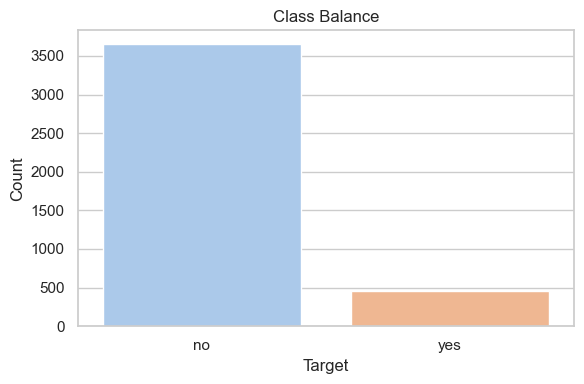

In [317]:
def plot_class_balance(mma, target):
    plt.figure(figsize=(6, 4))
    sns.countplot(data=mma, x=target, palette="pastel")
    plt.title("Class Balance")
    plt.xlabel("Target")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

plot_class_balance(mma, target_col)

## Outliers 

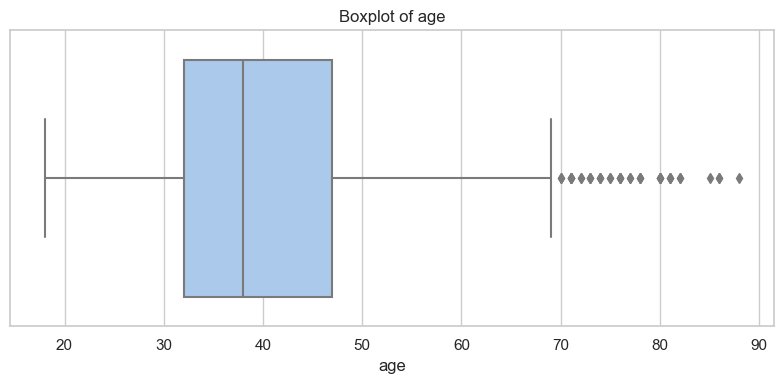

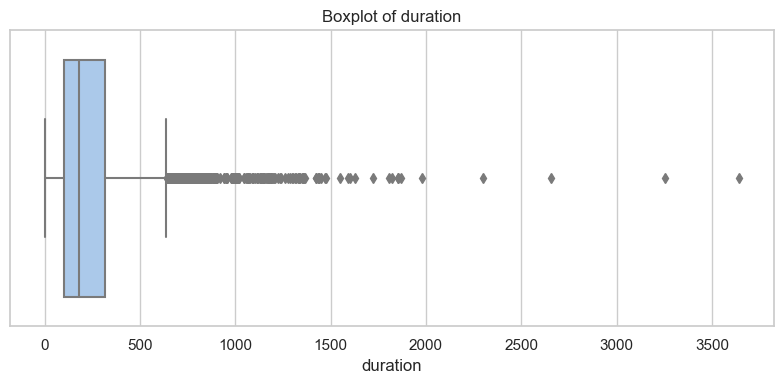

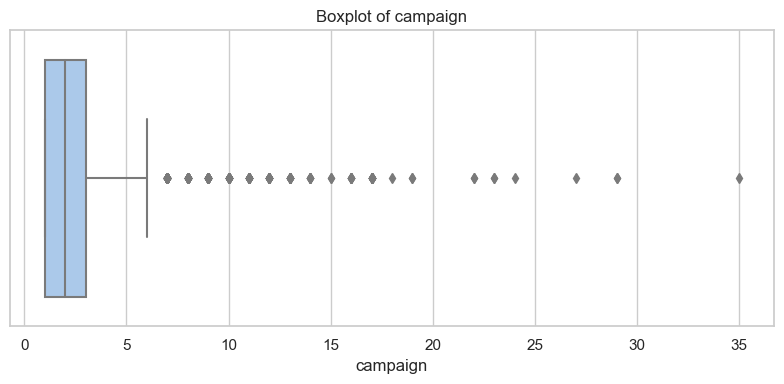

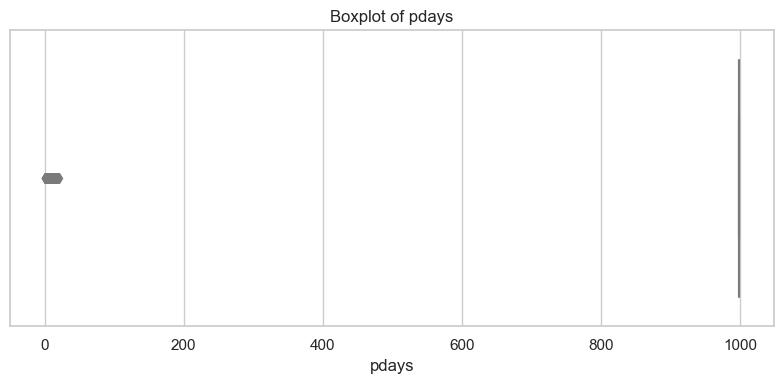

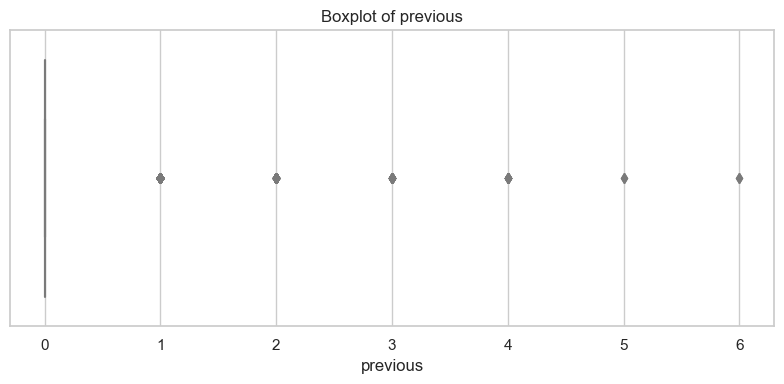

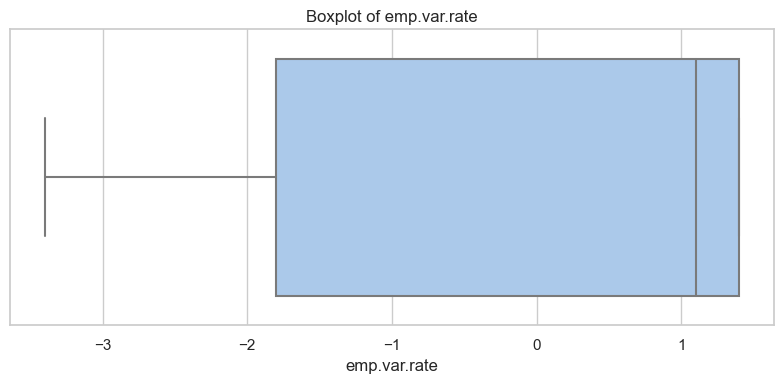

In [319]:
def plot_outliers(mma, num_cols, max_plots=6):
    cols_to_plot = num_cols[:max_plots]
    for col in cols_to_plot:
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=mma[col], palette="pastel")
        plt.title(f'Boxplot of {col}')
        plt.tight_layout()
        plt.show()

plot_outliers(mma, numerical_cols)

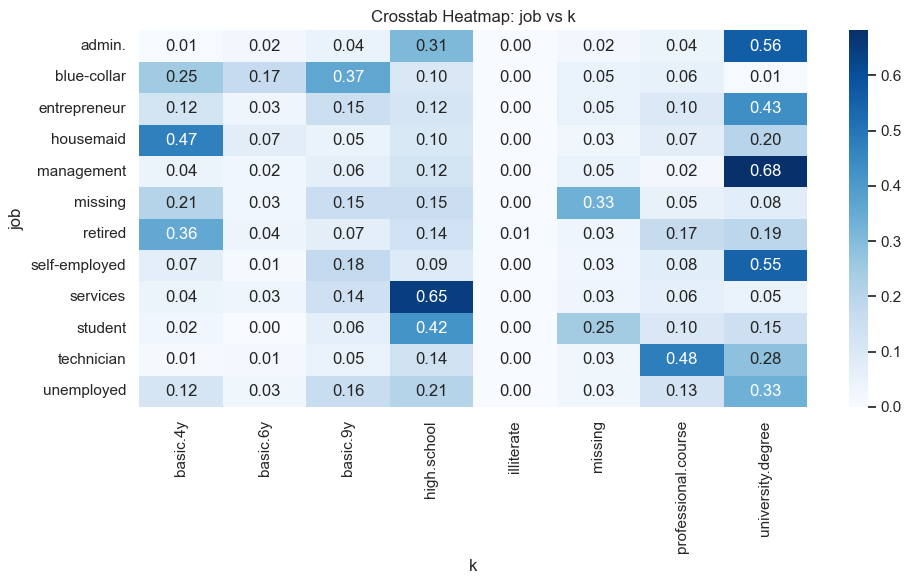

In [320]:
def plot_crosstab_heatmap(mma, cat_col1, cat_col2):
    ct = pd.crosstab(mma[cat_col1], mma[cat_col2], normalize='index')
    plt.figure(figsize=(10, 6))
    sns.heatmap(ct, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f'Crosstab Heatmap: {cat_col1} vs {cat_col2}')
    plt.tight_layout()
    plt.show()

plot_crosstab_heatmap(mma, 'job', 'education' if 'education' in mma.columns else 'k')

### Blue-collar, housemaid, and retired are mostly concentrated in basic education. This may correlate with lower financial literacy or less likelihood to subscribe to complex products like term deposits.

### Admin, management, and self-employed are dominated by university-level education. These groups may be more financially capable or receptive to investment-based products.

## Is response rate affected by contact type?

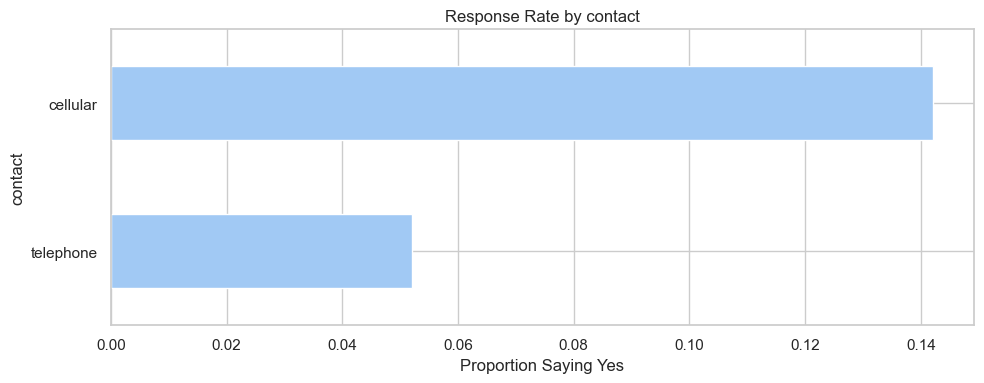

In [323]:
def plot_response_rate_by_category(mma, cat_col, target):
    response_rate = mma.groupby(cat_col)[target].value_counts(normalize=True).unstack()
    if 'yes' in response_rate.columns:
        palette_color = sns.color_palette("pastel")[0] 
        plt.figure(figsize=(10, 4))
        response_rate['yes'].sort_values().plot(
            kind='barh',
            color=palette_color
        )
        plt.title(f'Response Rate by {cat_col}')
        plt.xlabel("Proportion Saying Yes")
        plt.tight_layout()
        plt.show()
    else:
        print(f"'yes' not found in column '{target}'.")
        
plot_response_rate_by_category(mma, 'contact', target_col)

## Which age group is more likely to respond?

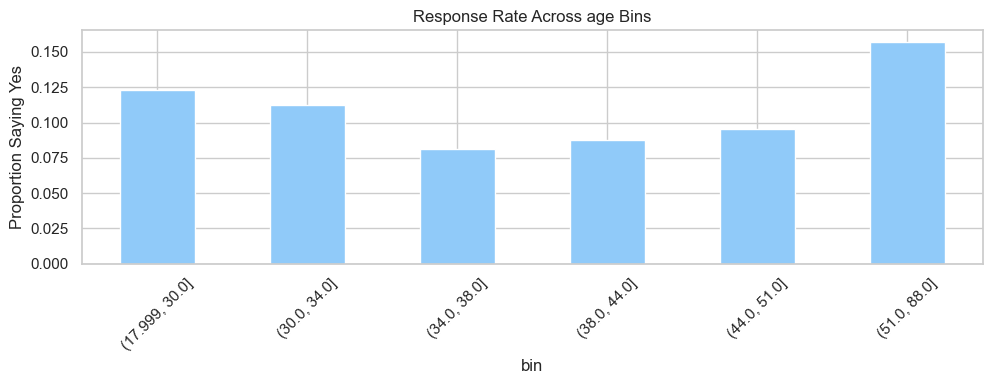

In [325]:
def plot_binned_response(mma, num_col, bins=5):
    mma['bin'] = pd.qcut(mma[num_col], q=bins, duplicates='drop')
    bin_response = mma.groupby('bin')[target_col].value_counts(normalize=True).unstack()
    
    if 'yes' in bin_response.columns:
        plt.figure(figsize=(10, 4))
        bin_response['yes'].plot(
            kind='bar',
            color='#90caf9'  # Custom pastel blue
        )
        plt.title(f'Response Rate Across {num_col} Bins')
        plt.ylabel("Proportion Saying Yes")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"'yes' not found in column '{target_col}'.")
    
    mma.drop(columns=['bin'], inplace=True)


plot_binned_response(mma, 'age', bins=6)

# Part 2: Statistical modelling 


## Anova 

In [356]:
from scipy.stats import f_oneway
from sklearn.decomposition import PCA

In [358]:
def run_anova(df, target='y'):
    print("🔍 ANOVA: Testing whether means of numerical features differ by target class ('y')\n")
    results = {}
    for col in mma.select_dtypes(include=['int64', 'float64']).columns:
        groups = [group[col].values for name, group in mma.groupby(target)]
        stat, p = f_oneway(*groups)
        results[col] = {'F-Statistic': stat, 'p-value': p}
    
    anova_df = pd.DataFrame(results).T.sort_values('p-value')
    return anova_df

anova_results = run_anova(mma)
anova_results.head()

🔍 ANOVA: Testing whether means of numerical features differ by target class ('y')



,F-Statistic,p-value
duration,878.740582,3.902109e-175
nr.employed,572.542150,1.503133e-118
pdays,507.002438,5.967978e-106
euribor3m,403.323646,1.213902e-85
emp.var.rate,359.483276,6.549778e-77


### Very low p-values, indicating strong evidence that the mean values differ between 'yes' and 'no' groups. However, duration is the strongest differentiator — consistent with earlier EDA

## K-means

In [363]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def run_kmeans(mma, n_clusters=3):
    df_clust = mma.copy()

    for col in df_clust.select_dtypes(include='object'):
        df_clust[col] = LabelEncoder().fit_transform(df_clust[col])
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_clust.drop('y', axis=1))

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    
    df_clust['Cluster'] = clusters

    cluster_summary = df_clust.groupby('Cluster').mean().round(2)

    return df_clust, cluster_summary

clustered_df, cluster_summary = run_kmeans(mma, n_clusters=3)
cluster_summary


,age,job,marital,k,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
Cluster,,,,,,,,,,,,,,,,,,,,,
0,40.02,4.09,1.39,4.07,0.76,1.48,1.14,0.49,4.08,2.06,...,2.82,999.00,0.00,1.00,1.14,93.85,-39.41,4.83,5213.92,0.05
1,42.34,4.33,1.68,4.85,0.98,1.56,1.12,0.07,4.92,1.92,...,1.79,5.86,1.78,1.78,-2.02,93.41,-38.40,1.02,5026.46,0.62
2,40.04,4.28,1.56,4.18,0.89,1.54,1.14,0.10,4.68,1.93,...,2.03,999.00,0.39,0.66,-1.91,93.02,-43.10,1.37,5082.92,0.18


### Cluster 0 contains most likely subscribers. They:
    ### Had prior contacts (pdays ≠ 999, previous > 0)
    ### Experienced longer calls
    ### Were reached during bad economic times (low euribor3m, negative emp.var.rate)

### Cluster 1 is the least responsive:
    ### No previous contact (pdays=999)
    ### High interest rates and stable employment suggest less urgency to change banks

### Cluster 2 sits in between — some might convert with the right strategy

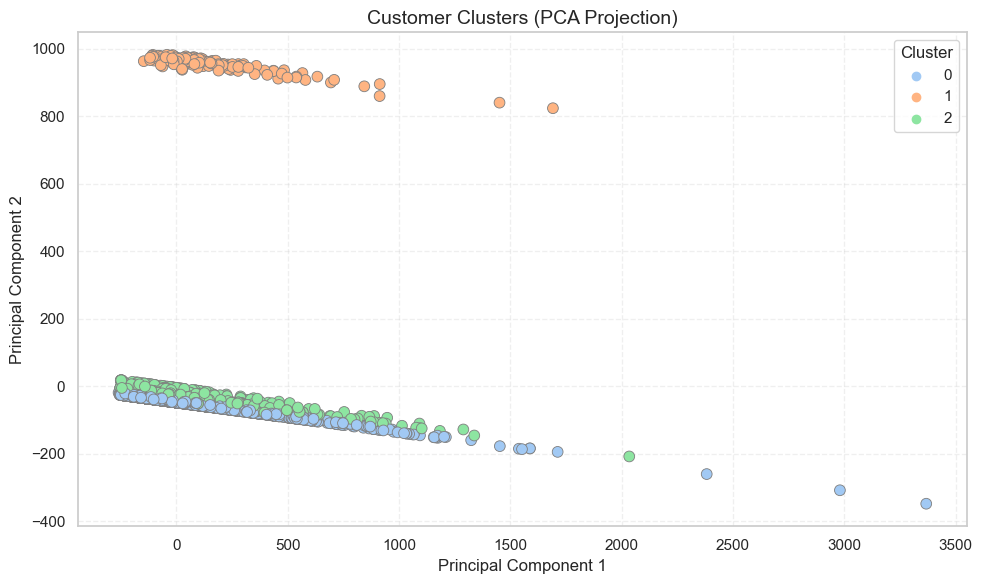

In [366]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters_2d(df_clustered):
    df_encoded = df_clustered.copy()

    y_cluster = df_encoded['Cluster']
    X = df_encoded.drop(['Cluster', 'y'], axis=1)

    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    df_encoded['PC1'] = components[:, 0]
    df_encoded['PC2'] = components[:, 1]

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_encoded, x='PC1', y='PC2',
        hue='Cluster', palette='pastel', s=60, edgecolor='gray'
    )
    plt.title("Customer Clusters (PCA Projection)", fontsize=14)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_clusters_2d(clustered_df)

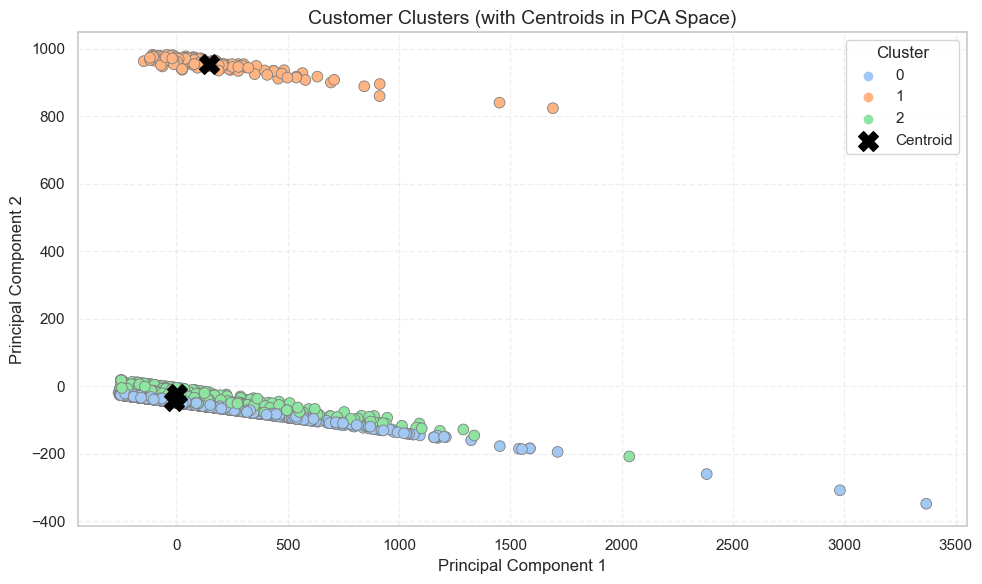

In [371]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters_with_centroids(df_clustered):
    df_encoded = df_clustered.copy()

    y_cluster = df_encoded['Cluster']
    X = df_encoded.drop(['Cluster', 'y'], axis=1)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)

    df_encoded['PC1'] = X_pca[:, 0]
    df_encoded['PC2'] = X_pca[:, 1]

    centroids = df_encoded.groupby('Cluster')[['PC1', 'PC2']].mean()

    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=df_encoded, x='PC1', y='PC2',
        hue='Cluster', palette='pastel', s=60, edgecolor='gray'
    )

    plt.scatter(
        centroids['PC1'], centroids['PC2'],
        s=200, c='black', marker='X', label='Centroid'
    )

    plt.title("Customer Clusters (with Centroids in PCA Space)", fontsize=14)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()


plot_clusters_with_centroids(clustered_df)

## Clusters by subscription rate with centroids

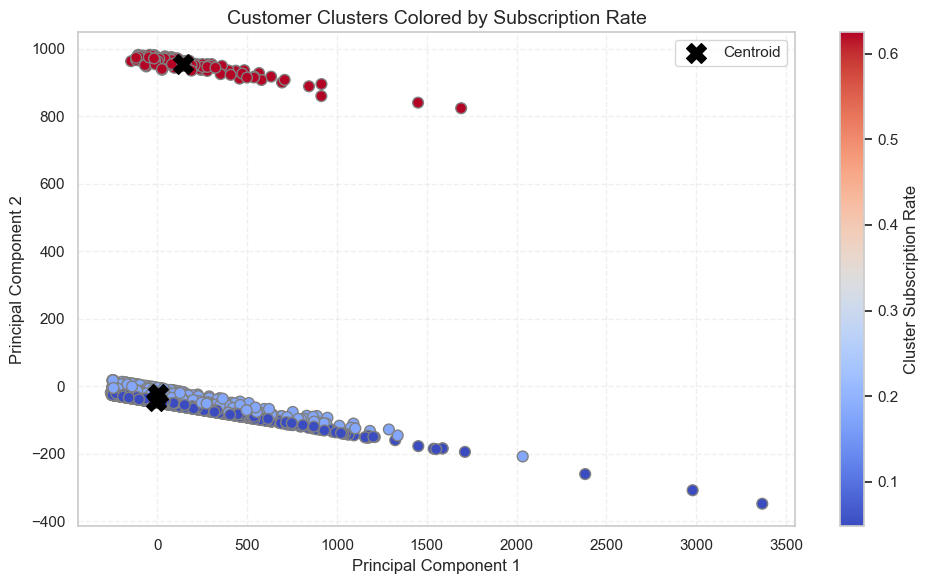

In [375]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters_by_response(df_clustered):
    df_encoded = df_clustered.copy()

    clusters = df_encoded['Cluster']
    y_target = df_encoded['y']
    X = df_encoded.drop(['Cluster', 'y'], axis=1)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    df_encoded['PC1'] = X_pca[:, 0]
    df_encoded['PC2'] = X_pca[:, 1]


    response_rates = df_encoded.groupby(clusters)['y'].mean()


    df_encoded['Cluster_Response_Rate'] = df_encoded['Cluster'].map(response_rates)


    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        df_encoded['PC1'], df_encoded['PC2'],
        c=df_encoded['Cluster_Response_Rate'],
        cmap='coolwarm', s=60, edgecolor='gray'
    )

    centroids = df_encoded.groupby('Cluster')[['PC1', 'PC2']].mean()
    plt.scatter(
        centroids['PC1'], centroids['PC2'],
        s=200, c='black', marker='X', label='Centroid'
    )

    plt.colorbar(scatter, label='Cluster Subscription Rate')
    plt.title("Customer Clusters Colored by Subscription Rate", fontsize=14)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
plot_clusters_by_response(clustered_df)

## Variable importance / Random forest

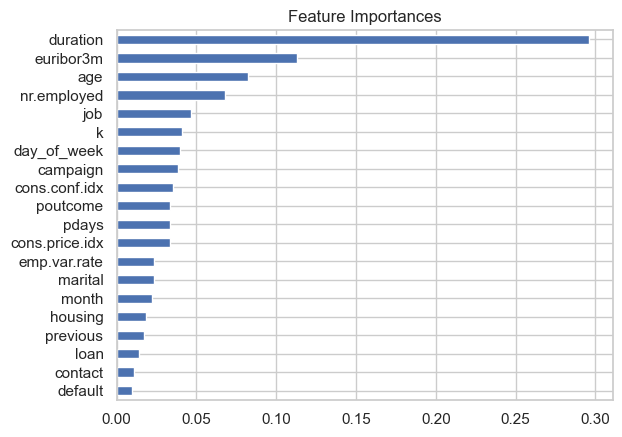

In [379]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

df_encoded = mma.copy()
for col in df_encoded.select_dtypes('object'):
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

model = RandomForestClassifier()
model.fit(df_encoded.drop('y', axis=1), df_encoded['y'])

feat_imp = pd.Series(model.feature_importances_, index=df_encoded.columns.drop('y')).sort_values()
feat_imp.plot(kind='barh', title="Feature Importances")
plt.show()


✅ Accuracy: 0.9171
✅ ROC AUC: 0.9393

Classification Report:
              precision    recall  f1-score   support

          no       0.94      0.97      0.95       737
         yes       0.62      0.47      0.53        83

    accuracy                           0.92       820
   macro avg       0.78      0.72      0.74       820
weighted avg       0.91      0.92      0.91       820



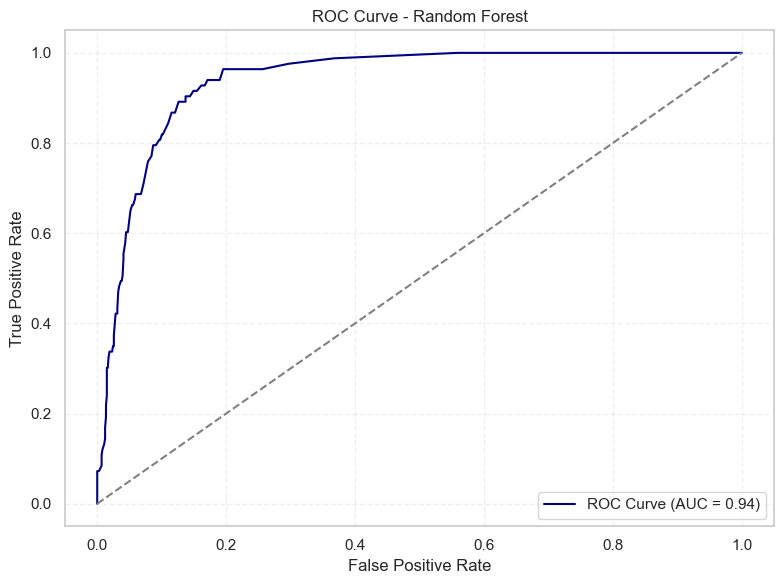

In [382]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df_model = mma.copy()
for col in df_model.select_dtypes(include='object'):
    df_model[col] = LabelEncoder().fit_transform(df_model[col])

X = df_model.drop('y', axis=1)
y = df_model['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(f"✅ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['no', 'yes']))

fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})", color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## logistic regression

In [394]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# One-hot encode
df_encoded = pd.get_dummies(mma, drop_first=True)

# Identify the target column
target_col = [col for col in df_encoded.columns if col.startswith('y_')][0]

# Define X and y
X = df_encoded.drop(columns=target_col)
y = df_encoded[target_col]

# Force numeric types (the fix)
X = X.astype(float)
y = y.astype(float)

# Add intercept
X_const = sm.add_constant(X)

# Fit logistic regression model
logit_model = sm.Logit(y, X_const).fit()

# Display summary
print(logit_model.summary2())


Optimization terminated successfully.
         Current function value: 0.193034
         Iterations 18
                                                    Results: Logit
Model:                                Logit                             Method:                            MLE        
Dependent Variable:                   y_yes                             Pseudo R-squared:                  0.443      
Date:                                 2025-03-23 14:12                  AIC:                               1690.8787  
No. Observations:                     4100                              BIC:                               2032.0908  
Df Model:                             53                                Log-Likelihood:                    -791.44    
Df Residuals:                         4046                              LL-Null:                           -1420.7    
Converged:                            1.0000                            LLR p-value:                       1.5932e-2

✅ Accuracy: 0.9168

Classification Report:
              precision    recall  f1-score   support

          no       0.93      0.97      0.95      3649
         yes       0.69      0.45      0.54       451

    accuracy                           0.92      4100
   macro avg       0.81      0.71      0.75      4100
weighted avg       0.91      0.92      0.91      4100



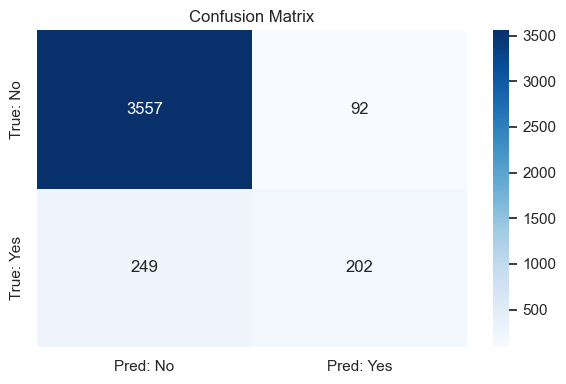

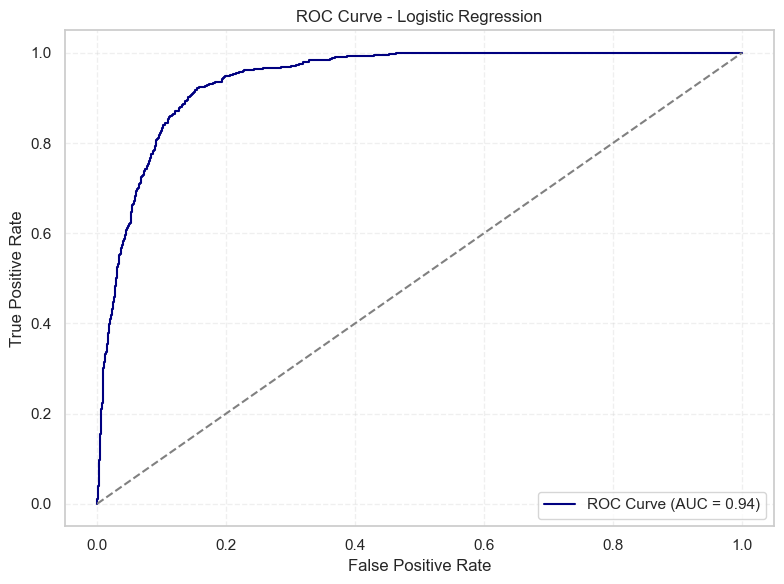

In [398]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, roc_curve, roc_auc_score
)

y_proba = logit_model.predict(X_const)

y_pred = (y_proba >= 0.5).astype(int)

print(f"✅ Accuracy: {accuracy_score(y, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y, y_pred, target_names=["no", "yes"]))

cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: No', 'Pred: Yes'], yticklabels=['True: No', 'True: Yes'])
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(y, y_proba)
roc_auc = roc_auc_score(y, y_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color='navy')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## Comparing Logistic regression with Random Forest Model and XG Boost and evaluating them

In [414]:
import sys
!{sys.executable} -m pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/95/6c/d2a1636591e204667f320481b036acc9c526608bcc2319be71cce148102d/xgboost-3.0.0-py3-none-macosx_10_15_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.0 MB/s eta 0:00:00a 0:00:01


In [424]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import pandas as pd

X = df_encoded.drop(columns=target_col)
y = df_encoded[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_test_const = sm.add_constant(X_test, has_constant='add')
model_columns = logit_model.model.exog_names
X_test_const = X_test_const[model_columns]     # reorder columns to match training
X_test_const = X_test_const.astype(float)      # ensure correct numeric types

y_logit_proba = logit_model.predict(X_test_const)
y_logit_pred = (y_logit_proba >= 0.5).astype(int)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test)
y_rf_proba = rf.predict_proba(X_test)[:, 1]

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
y_xgb_proba = xgb.predict_proba(X_test)[:, 1]

comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        accuracy_score(y_test, y_logit_pred),
        accuracy_score(y_test, y_rf_pred),
        accuracy_score(y_test, y_xgb_pred)
    ],
    "ROC AUC": [
        roc_auc_score(y_test, y_logit_proba),
        roc_auc_score(y_test, y_rf_proba),
        roc_auc_score(y_test, y_xgb_proba)
    ]
})

print(comparison.round(4))


                 Model  Accuracy  ROC AUC
0  Logistic Regression    0.9244   0.9500
1        Random Forest    0.9134   0.9300
2              XGBoost    0.9134   0.9357


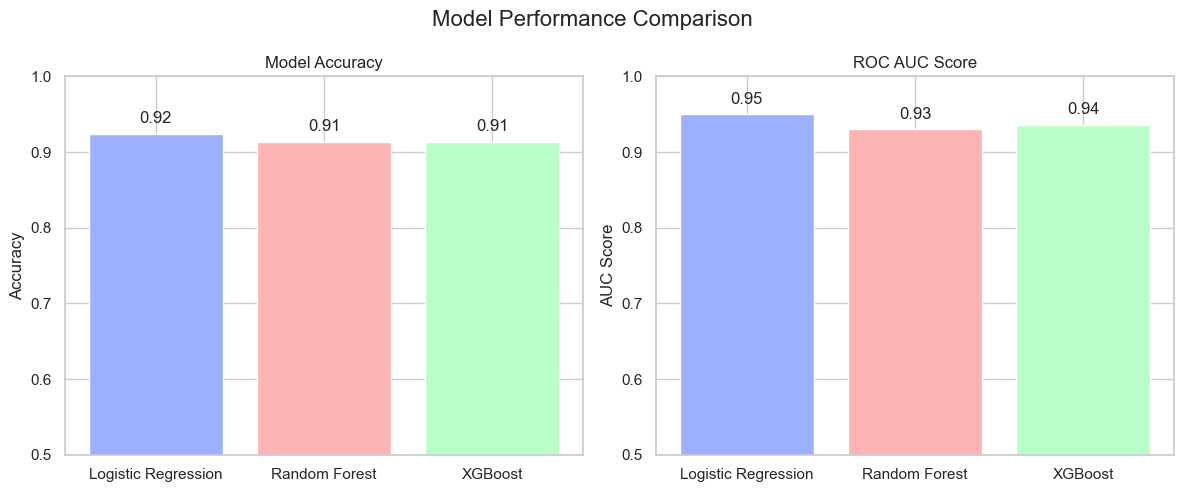

In [430]:
import matplotlib.pyplot as plt

def plot_model_comparison(df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    axes[0].bar(df['Model'], df['Accuracy'], color=['#9bb1ff', '#ffb4b4', '#baffc9'])
    axes[0].set_title('Model Accuracy')
    axes[0].set_ylim(0.5, 1)
    axes[0].set_ylabel('Accuracy')
    for i, val in enumerate(df['Accuracy']):
        axes[0].text(i, val + 0.01, f"{val:.2f}", ha='center', va='bottom')

    axes[1].bar(df['Model'], df['ROC AUC'], color=['#9bb1ff', '#ffb4b4', '#baffc9'])
    axes[1].set_title('ROC AUC Score')
    axes[1].set_ylim(0.5, 1)
    axes[1].set_ylabel('AUC Score')
    for i, val in enumerate(df['ROC AUC']):
        axes[1].text(i, val + 0.01, f"{val:.2f}", ha='center', va='bottom')

    plt.suptitle("Model Performance Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_model_comparison(comparison)


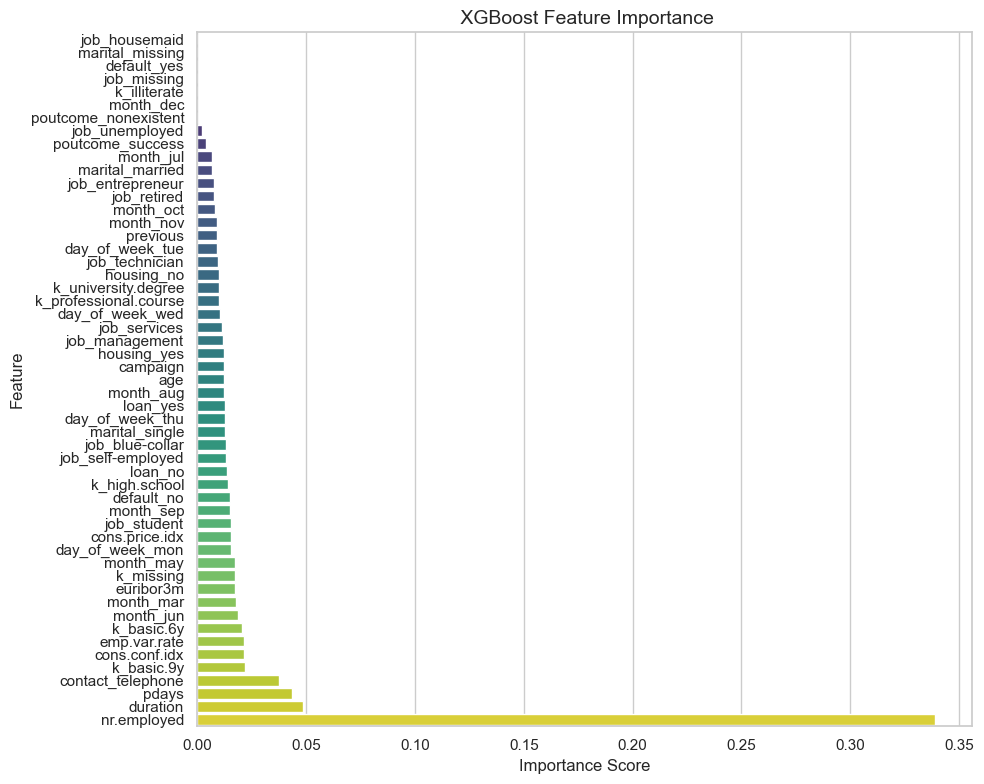

In [436]:

mma = pd.read_csv("Desktop/MMA.csv")


def clean_unknowns(df):
    df_clean = df.copy()
    for col in ['default', 'k', 'housing', 'loan', 'job', 'marital']:
        df_clean[col] = df_clean[col].replace('unknown', 'missing')
    return df_clean

mma = clean_unknowns(mma)


df_encoded = pd.get_dummies(mma, drop_first=True)
target_col = [col for col in df_encoded.columns if col.startswith('y_')][0]


X = df_encoded.drop(columns=target_col)
y = df_encoded[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train, y_train)


feature_importances = pd.Series(xgb.feature_importances_, index=X.columns).sort_values(ascending=True)


plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances, y=feature_importances.index, palette="viridis")
plt.title(" XGBoost Feature Importance", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Limit features

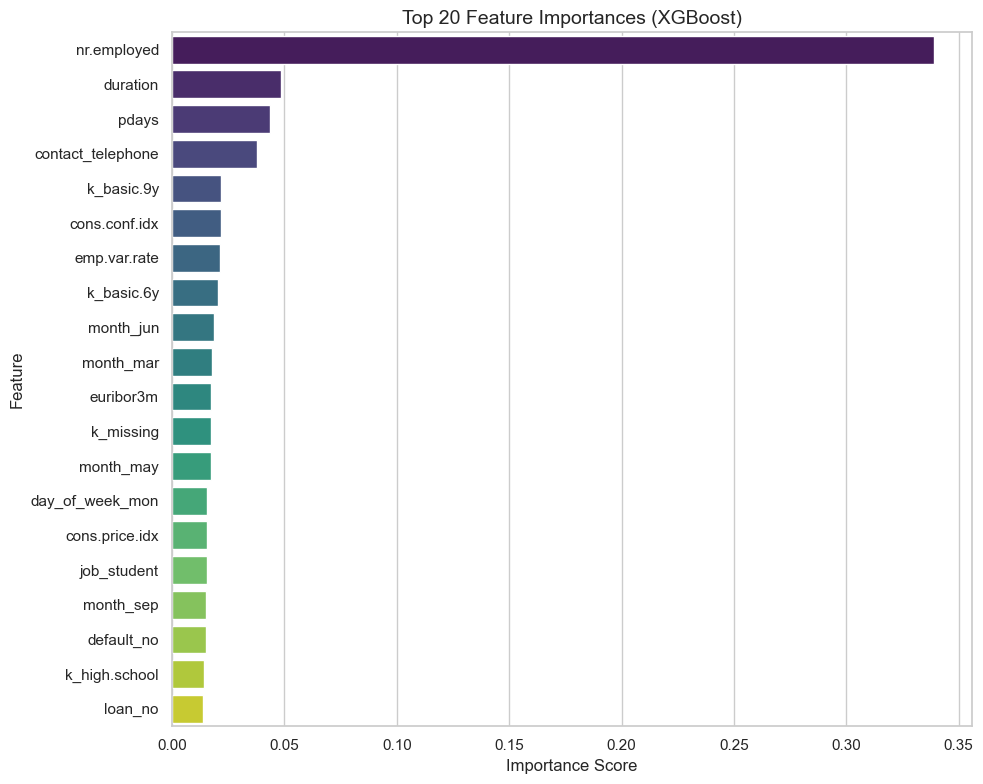

In [438]:
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import pandas as pd

# Load and clean your data
mma = pd.read_csv("Desktop/MMA.csv")

def clean_unknowns(df):
    df_clean = df.copy()
    for col in ['default', 'k', 'housing', 'loan', 'job', 'marital']:
        df_clean[col] = df_clean[col].replace('unknown', 'missing')
    return df_clean

mma = clean_unknowns(mma)
df_encoded = pd.get_dummies(mma, drop_first=True)
target_col = [col for col in df_encoded.columns if col.startswith('y_')][0]

# Split data
X = df_encoded.drop(columns=target_col)
y = df_encoded[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost with faster settings
xgb = XGBClassifier(eval_metric='logloss', n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Get top 20 features
feature_importances = pd.Series(xgb.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(x=top_features, y=top_features.index, palette="viridis")
plt.title("Top 20 Feature Importances (XGBoost)", fontsize=14)
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Confusion Matrix for XG boost

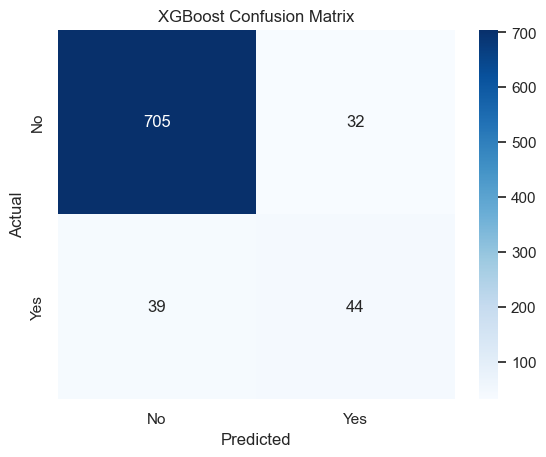

              precision    recall  f1-score   support

          no       0.95      0.96      0.95       737
         yes       0.58      0.53      0.55        83

    accuracy                           0.91       820
   macro avg       0.76      0.74      0.75       820
weighted avg       0.91      0.91      0.91       820



In [442]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(y_test, y_xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(y_test, y_xgb_pred, target_names=['no', 'yes']))


In [ ]:
## Sharp values for individual prediction explanation

In [444]:
pip install shap


  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/c3/65/ccad788e04eff97de1afb0e3c46fedbb0690bfc1366aa0291bc6454b3550/shap-0.47.1-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 498.9/498.9 kB 8.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


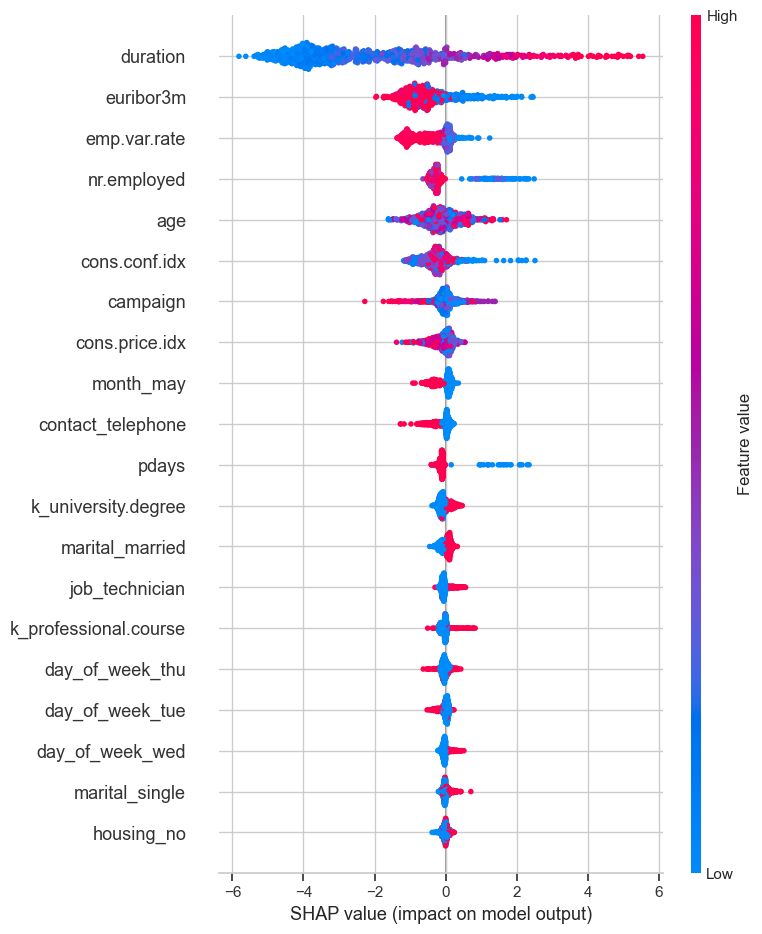

In [450]:
import shap
shap.initjs()

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)


shap.summary_plot(shap_values, X_test)
